# Descargar DEM ajustado al área de la imagen RGB de Sentinel-2  
*Conjunto de datos: [COP-DEM GLO-30](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30)*

In [1]:
import numpy as np
import rasterio
import planetary_computer
import matplotlib.pyplot as plt

from rasterio.warp import transform_bounds, reproject, Resampling
from rasterio.merge import merge
from pystac_client import Client

import warnings
warnings.filterwarnings("ignore")

In [2]:
s2_path = "sentinel2_rgb.tif"
out_dem_path = "dem.tif"

In [3]:
def show_tif(tif_path, band_names):
    """
    Visualiza un GeoTIFF aplicando un *stretch* del 2–98% a las bandas seleccionadas.
    band_names ej.: ["B04","B03","B02"] (RGB)
    """

    with rasterio.open(tif_path) as src:
        img = src.read()                      # (bands, H, W)
        desc = list(src.descriptions)         # nombres de las bandas almacenadas

    # Mapeo: nombre de banda → índice
    band_indices = []
    for name in band_names:
        if name not in desc:
            raise ValueError(f"No se encontró la banda '{name}' en el GeoTIFF")
        band_indices.append(desc.index(name))

    selected = img[band_indices, :, :]

    # Stretch 2–98%
    def stretch(arr):
        p2 = np.percentile(arr, 2)
        p98 = np.percentile(arr, 98)
        arr_clip = np.clip(arr, p2, p98)
        return (arr_clip - p2) / (p98 - p2 + 1e-6)

    # Una sola banda
    if selected.shape[0] == 1:
        stretched = stretch(selected[0])
        plt.figure(figsize=(6,6))
        plt.imshow(stretched, cmap='terrain')
        plt.axis("off")
        plt.title(f"{tif_path}\nBanda: {band_names[0]}")
        plt.show()

    # Varias bandas (RGB, etc.)
    else:
        stretched_bands = [stretch(selected[i]) for i in range(selected.shape[0])]
        rgb = np.stack(stretched_bands, axis=-1)
        plt.figure(figsize=(6,6))
        plt.imshow(rgb)
        plt.axis("off")
        plt.title(f"{tif_path}\nBandas: {band_names}")
        plt.show()

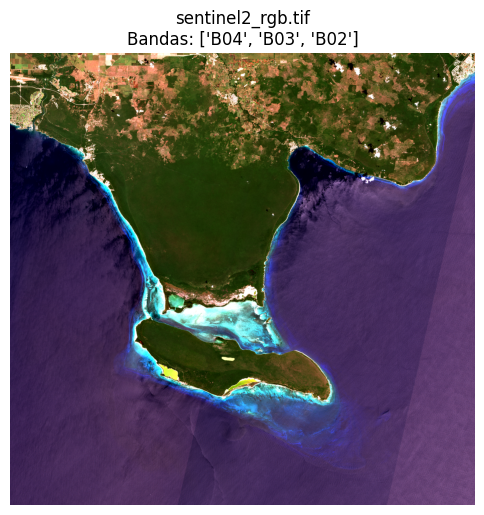

In [4]:
show_tif("sentinel2_rgb.tif", ["B04", "B03", "B02"])

In [5]:
def get_s2_bbox_wgs84(s2_path):
    """
    Convierte la extensión espacial de `sentinel2_rgb.tif` a un BBox en WGS84.

    Returns
    -------
    bbox_wgs84 : tuple
        (min_lon, min_lat, max_lon, max_lat)
    profile : dict
        Perfil rasterio del archivo `sentinel2_rgb.tif`
    """
    with rasterio.open(s2_path) as src:
        bounds = src.bounds
        crs = src.crs
        profile = src.profile

    # Bounding box en WGS84 para búsqueda STAC
    bbox_wgs84 = transform_bounds(
        crs,
        "EPSG:4326",
        bounds.left,
        bounds.bottom,
        bounds.right,
        bounds.top,
        densify_pts=21,
    )
    return bbox_wgs84, profile

In [6]:
# Leer el bbox (WGS84) y el perfil del Sentinel-2 RGB
bbox_wgs84, s2_profile = get_s2_bbox_wgs84(s2_path)
print("BBox de Sentinel-2 (WGS84):", bbox_wgs84)
print("CRS de Sentinel-2:", s2_profile["crs"])

BBox de Sentinel-2 (WGS84): (-68.92405248166772, 17.99922814815082, -68.40695965660555, 18.479964791218272)
CRS de Sentinel-2: EPSG:32619


In [7]:
def download_and_mosaic_dem(bbox_wgs84,
                            collection_id="cop-dem-glo-30",
                            dem_asset_key="data"):
    """
    Busca y descarga desde Microsoft Planetary Computer los mosaicos del
    COP-DEM GLO-30 que cubren el BBox en WGS84 indicado, los une en un 
    solo DEM y devuelve el arreglo resultante junto con su transform 
    y su CRS.

    Parameters
    ----------
    bbox_wgs84 : tuple
        (min_lon, min_lat, max_lon, max_lat)
    collection_id : str
        ID de la colección en MPC (por defecto: "cop-dem-glo-30")
    dem_asset_key : str
        Clave del asset que contiene el DEM (por ejemplo: "data" o "elevation")

    Returns
    -------
    mosaic : np.ndarray (1, H, W)
    mosaic_transform : affine.Affine
    mosaic_crs : rasterio.crs.CRS
    """

    # Conectar con el catálogo STAC de Planetary Computer
    catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    # Buscar los mosaicos DEM que cubren el bbox en WGS84
    search = catalog.search(
        collections=[collection_id],
        bbox=bbox_wgs84,
    )
    items = list(search.get_items())
    print(f"DEM items encontrados: {len(items)}")
    if not items:
        raise RuntimeError("No se encontraron mosaicos DEM que cubran este BBox.")

    dem_datasets = []
    for item in items:
        asset = item.assets[dem_asset_key]
        href = asset.href  # URL con token SAS gracias a sign_inplace
        print("Usando DEM del item:", item.id)
        src = rasterio.open(href)
        dem_datasets.append(src)

    # Unir (mosaic) los mosaicos DEM
    mosaic, mosaic_transform = merge(dem_datasets)
    mosaic_crs = dem_datasets[0].crs

    # Convertir a float32
    mosaic = mosaic.astype("float32")

    # Cerrar datasets abiertos
    for ds in dem_datasets:
        ds.close()

    return mosaic, mosaic_transform, mosaic_crs

In [8]:
# Obtener el mosaico DEM que cubre el BBox desde MPC
dem_mosaic, dem_transform, dem_crs = download_and_mosaic_dem(
    bbox_wgs84,
    collection_id="cop-dem-glo-30",
    dem_asset_key="data",
)
print("CRS del DEM:", dem_crs)

DEM items encontrados: 1
Usando DEM del item: Copernicus_DSM_COG_10_N18_00_W069_00_DEM
CRS del DEM: EPSG:4326


In [9]:
def reproject_dem_to_s2_grid(dem_mosaic, dem_transform, dem_crs, s2_profile):
    """
    Reproyecta y remuestrea el mosaico DEM al mismo grid/CRS que el archivo sentinel2_rgb.tif.

    Parameters
    ----------
    dem_mosaic : np.ndarray (1, H_dem, W_dem)
        Mosaico DEM original
    dem_transform : affine.Affine
        Transformación espacial del DEM
    dem_crs : rasterio.crs.CRS
        Sistema de referencia del DEM
    s2_profile : dict
        Perfil del archivo sentinel2_rgb.tif (height, width, crs, transform, etc.)

    Returns
    -------
    dem_resampled : np.ndarray (1, H_s2, W_s2)
        DEM remuestreado al grid de Sentinel-2
    """

    dst_height = s2_profile["height"]
    dst_width = s2_profile["width"]
    dst_transform = s2_profile["transform"]
    dst_crs = s2_profile["crs"]

    # Crear arreglo vacío con el tamaño del grid de Sentinel-2
    dem_resampled = np.empty((1, dst_height, dst_width), dtype="float32")

    # Reproyección y remuestreo
    reproject(
        source=dem_mosaic,
        destination=dem_resampled,
        src_transform=dem_transform,
        src_crs=dem_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear,
    )

    return dem_resampled

In [10]:
# Remuestrear el DEM al grid de Sentinel-2
dem_resampled = reproject_dem_to_s2_grid(
    dem_mosaic,
    dem_transform,
    dem_crs,
    s2_profile,
)

In [11]:
def save_dem_to_tif(
    dem_arr, s2_profile, out_path="dem_from_mpc.tif",
    nodata_value=-9999.0,
    band_name="elevation"
):
    """
    Guarda un arreglo DEM (1, H, W) como GeoTIFF utilizando el perfil
    de sentinel2_rgb.tif. Incluye el nombre de la banda (Description).
    """
    # Convertir NaN → nodata_value
    dem_to_save = np.where(np.isnan(dem_arr), nodata_value, dem_arr).astype("float32")

    profile = s2_profile.copy()
    profile.update(
        dtype="float32",
        count=1,
        nodata=nodata_value,
        compress="lzw",
    )

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(dem_to_save[0], 1)
        dst.set_band_description(1, band_name)

    print(f"DEM guardado en: {out_path}")

In [12]:
# Guardar el DEM ajustado al perfil de Sentinel-2
save_dem_to_tif(dem_resampled, s2_profile, out_dem_path)

DEM guardado en: dem.tif


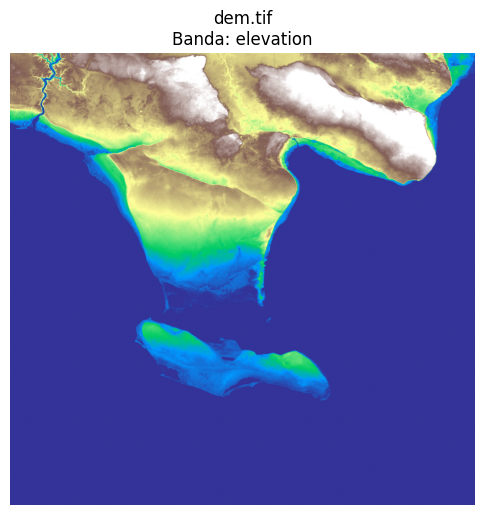

In [13]:
show_tif("dem.tif", ["elevation"])